# Secrets inside Clinton's email

## Abstract
In 2015, Hillary Clinton has been embroiled in controversy over the use of personal email accounts on non-government servers during her time as the United States Secretary of State. Over 2000 confidential emails were leaked, some of them are even classified as “Top Secret”. 

In this project we will look at the politic, security and economic aspects through the 7945 leaked emails redacted and published by the State Department and cleaned by Kaggle. We also want to analyze the personal social network of Hillary Clinton and the top topics they discussed.

As a superpower, the United States has a great impact on the world’s stability, and their position and attitude will strongly influence the international affairs. We want to figure out the countries mainly mentioned, the problems concerned and conclude the impact they made on the international affairs throughout the analysis of these emails.

The dataset can be found on [Kaggle](https://www.kaggle.com/kaggle/hillary-clinton-emails).

## Milestone 2
**Tasks for milestone 2**
* Data wrangling: clean and deal with unvalid or missing data
* Combine and merge data files for further analysis
* Find the communication frequency between Hillary and the others in both direction
* Construct a countries occurence list and visualization

---

## Data wrangling: Clean and deal with unuseful data

In [1]:
import numpy as np
import pandas as pd
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [2]:
data_folder = './hillary-clinton-emails/'

In [3]:
# load data and parse time to timestamp
emails_raw = pd.read_csv(data_folder + 'Emails.csv', parse_dates=['MetadataDateSent', 'MetadataDateReleased', 'ExtractedDateSent', 'ExtractedDateReleased'])

We extract information from the raw data in the following way:  
  
- **Release information**: some features in the data, for example `DocNumber`, are not of our concern. They are information of the release of the emails but not the information that the email itself tells. For this reason, we extract only useful features from the raw data.  
- **Redundant information**: there are also some features with a lot of `Nan` values, for example `ExtractedTo`. This overlaps with some information in `MetadataTo` and is not useful for our analysis, so we do not consider them. The `SenderPersonId` is a personId-parsed version of `MetadataTo`, so we also ignore this column.
- **Uncompleted data**: we have compare the `RawText` and `ExtractedBodyText`, and we deduce that the later is uncomplete. For textual information extraction we will only consider the first one.
- **Large data**: we extract the `RawText` from the raw data apart from the dataset because it is very large comparing to the other features. We will use this feature to mesure the textual information containing in the email, for example the countries mentioned ot other key words.

In [4]:
# extract useful information only
emails = emails_raw[['Id', 
                    'MetadataSubject',
                    'MetadataTo',
                    'SenderPersonId',
                    'MetadataDateSent',
                    'ExtractedReleaseInPartOrFull']]

# extract raw text for texual analysis
rawtext = emails_raw[['Id', 'RawText']]

In [5]:
# show emails
emails[:5]

,Id,MetadataSubject,MetadataTo,SenderPersonId,MetadataDateSent,ExtractedReleaseInPartOrFull
0,1,WOW,H,87.0,2012-09-12 04:00:00,RELEASE IN FULL
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,2011-03-03 05:00:00,RELEASE IN PART
2,3,CHRIS STEVENS,;H,32.0,2012-09-12 04:00:00,RELEASE IN PART
3,4,CAIRO CONDEMNATION - FINAL,H,32.0,2012-09-12 04:00:00,RELEASE IN PART
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",80.0,2011-03-11 05:00:00,RELEASE IN PART


In [6]:
emails.ExtractedReleaseInPartOrFull.unique()

array(['RELEASE IN FULL', 'RELEASE IN PART', 'UNKNOWN'], dtype=object)

We observe that `ExtractedReleaseInPartOfFull` seems to be categorical, so we decide to assign integer values to it.

In [7]:
str_vals = emails.ExtractedReleaseInPartOrFull.unique()
def part2int (x):
    if x == str_vals[0]:
        return 1
    elif x == str_vals[1]:
        return 0
    else:
        return -1

In [8]:
# attribute integer values for ExtractedReleaseInPartOrFull
emails.ExtractedReleaseInPartOrFull = emails.ExtractedReleaseInPartOrFull.apply(part2int)
emails = emails.rename(columns={'ExtractedReleaseInPartOrFull': 'is_Full'})
emails[:5]

,Id,MetadataSubject,MetadataTo,SenderPersonId,MetadataDateSent,is_Full
0,1,WOW,H,87.0,2012-09-12 04:00:00,1
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,2011-03-03 05:00:00,0
2,3,CHRIS STEVENS,;H,32.0,2012-09-12 04:00:00,0
3,4,CAIRO CONDEMNATION - FINAL,H,32.0,2012-09-12 04:00:00,0
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",80.0,2011-03-11 05:00:00,0


---

## Combine and merge data files: convert involved alias to PersonId
Information on sender and receiver in the `Emails.csv` is aliases. One person can have multiple alias, so it is not easy for us to make further analysis. We thus convert all involved aliases to the personId by using `Aliases.csv`.

In [9]:
# Load data of alias
alias = pd.read_csv(data_folder + 'Aliases.csv')

In [10]:
# rearrange strings to a basic form
def manage_str(s):
    s = re.sub(r'\<.*', '', s)
    s = re.sub(r'\(.*\)', '', s)
    return s.lower()\
            .replace(',', '').replace('-', '').replace(' ', '').replace("'", '').replace('‘', '')\
            .replace('`', '').replace('°', '').replace('"', '').replace('•', '').replace('(', '')\
            .replace(')', '')

In [11]:
# create a dictionary of alias and personId
dict_alias = dict(zip(alias.Alias.apply(manage_str), alias.PersonId))

In [12]:
# convert alias to personId
def alias2id(alias):
    aliases = str(alias).split(';')
    ids = []
    for x in aliases:
        x = manage_str(x)
        if x in dict_alias.keys():
            ids.append(dict_alias[x])
    return ids

In [13]:
# Convert from alias to personId for five features related to people
emails.MetadataTo = emails.MetadataTo.apply(alias2id)

In [14]:
# rename columns in a more intuitive way and show the processed data
emails = emails.rename(columns={'MetadataSubject':'Subject', 
                                'SenderPersonId':'From', 
                                'MetadataTo':'To', 
                                'MetadataDateSent':'Date'})
emails[:5]

,Id,Subject,To,From,Date,is_Full
0,1,WOW,[80],87.0,2012-09-12 04:00:00,1
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,[80],NaN,2011-03-03 05:00:00,0
2,3,CHRIS STEVENS,[80],32.0,2012-09-12 04:00:00,0
3,4,CAIRO CONDEMNATION - FINAL,[80],32.0,2012-09-12 04:00:00,0
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,[81],80.0,2011-03-11 05:00:00,0


---

## Find the communication frequency FROM and TO Hillary

### 1. Distribution of receivers of emails when the sender is Hillary

In [15]:
# load data of persons
persons = pd.read_csv(data_folder + 'Persons.csv')

In [16]:
# show data
persons[:5]

,Id,Name
0,1,111th Congress
1,2,AGNA USEMB Kabul Afghanistan
2,3,AP
3,4,ASUNCION
4,5,Alec


In [17]:
# dictionary that help searching for name of the person from its personId
dict_persons = dict(zip(persons.Id, persons.Name))

In [18]:
dict_persons[80]

'Hillary Clinton'

We observed from data that there are a lot of 80 values in the `To` and `From` column, and we verified that it is indeed Hillary Clinton - our petagonist.

In [19]:
# emails from Hillary to somebody
emails_H2sb = emails.loc[emails['From'] == 80]

In [20]:
# find all receivers
email_receivers = []
for i in emails_H2sb.To:
    for j in i:
        email_receivers.append(j)

In [21]:
# count for occurency
dict_receiver_count = dict(Counter(email_receivers))

In [22]:
# construct a dataframe for receiver and occurence
receiver_Ids = [ k for k in dict_receiver_count ]
receiver_occurences = [ v for v in dict_receiver_count.values() ]
receiver_count = pd.DataFrame({'receiver': receiver_Ids, 'occurence': receiver_occurences})

# sort by occurence and take the most important receivers
receiver_count = receiver_count.sort_values('occurence', ascending=False)
important_receiver = receiver_count[:15]

In [23]:
# convert receiver ids to names
names = []
for i in important_receiver.receiver:
    names.append(dict_persons[i])

important_receiver['name'] = names
important_receiver = important_receiver[['name', 'occurence']] # only keep information we need
important_receiver

,name,occurence
5,Cheryl Mills,354
4,a bed in h@state.gov,350
2,sulliva njj@state.g ov,297
7,Lauren Jiloty,234
8,Lona Valmoro,141
13,p rei n es,51
38,Sidney Blumenthal,50
0,Huma Abedin,37
6,ha nleym r@state.gov,33
64,Richard Verma,30


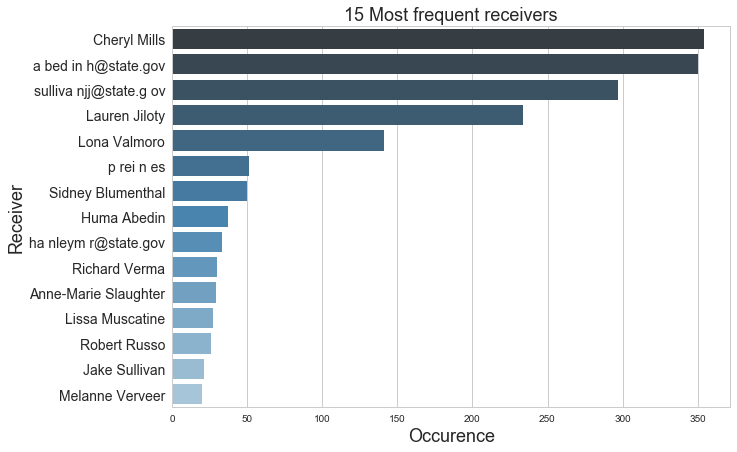

In [24]:
# plot a barplot of the most frequent receivers 
sns.set(style="whitegrid", rc={'figure.figsize':(10, 7)})
ax = sns.barplot(data = important_receiver, y="name", x="occurence", palette="Blues_d")
ax.set_title('15 Most frequent receivers', size=18)
ax.set_yticklabels(important_receiver.name, size = 14)
ax.set_xlabel('Occurence', size = 18)
ax.set_ylabel('Receiver', size = 18);

Some names don't seem to be clean data. We will analyze these people afterwards.

### 2. Distribution of sender of emails when the receiver is Hillary

In [25]:
emails[:5]

,Id,Subject,To,From,Date,is_Full
0,1,WOW,[80],87.0,2012-09-12 04:00:00,1
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,[80],NaN,2011-03-03 05:00:00,0
2,3,CHRIS STEVENS,[80],32.0,2012-09-12 04:00:00,0
3,4,CAIRO CONDEMNATION - FINAL,[80],32.0,2012-09-12 04:00:00,0
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,[81],80.0,2011-03-11 05:00:00,0


We want to verify whether we can parse a list of receivers to a single receiver. We can do this only if the list always contains 0 or 1 receiver.

In [26]:
# search for multi-receiver emails
multiple_receivers = []
for i in emails['To']:
    if len(i)>1:
        multiple_receivers.append(len(i))
multiple_receivers

[2, 2, 2, 2, 2, 2, 2, 2, 2]

So we cannot :(

In [27]:
# emails from somebody to Hillary
emails_sb2H_index = []
for index, email in emails.iterrows():
    if 80 in email.To:
        emails_sb2H_index.append(True)
    else:
        emails_sb2H_index.append(False)

emails_sb2H = emails[emails_sb2H_index]

In [28]:
# find all senders
email_senders = emails_sb2H.From.dropna()

In [29]:
# count for occurency
dict_sender_count = dict(Counter(email_senders))

In [30]:
# construct a dataframe for sender and occurence
sender_Ids = [ k for k in dict_sender_count ]
sender_occurences = [ v for v in dict_sender_count.values() ]
sender_count = pd.DataFrame({'sender': sender_Ids, 'occurence': sender_occurences})

# sort by occurence and take the most important senders
sender_count = sender_count.sort_values('occurence', ascending=False)
important_sender = sender_count[:15]

In [31]:
# convert sender ids to names
names = []
for i in important_sender.sender:
    names.append(dict_persons[i])

important_sender['name'] = names
important_sender = important_sender[['name', 'occurence']] # only keep information we need
important_sender

,name,occurence
7,Huma Abedin,1370
1,Cheryl Mills,1244
0,Jake Sullivan,840
5,Sidney Blumenthal,362
20,Lauren Jiloty,333
14,Philippe Reines,149
15,Lona Valmoro,141
2,Anne-Marie Slaughter,130
35,Richard Verma,117
12,Melanne Verveer,95


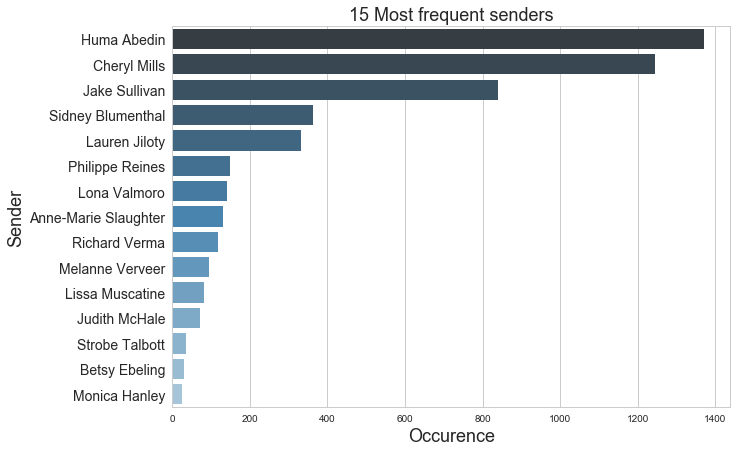

In [32]:
# plot a barplot of the most frequent senders 
sns.set(style="whitegrid", rc={'figure.figsize':(10, 7)})
ax = sns.barplot(data = important_sender, y="name", x="occurence", palette="Blues_d")
ax.set_title('15 Most frequent senders', size=18)
ax.set_yticklabels(important_sender.name, size = 14)
ax.set_xlabel('Occurence', size = 18)
ax.set_ylabel('Sender', size = 18);

There are some people who are much closer to Hillary, again, we will analyze them later.  
  
An interesting observation: Huma Abedin, the person that receives the most emails FROM Hillary, is only the 8-th sender of emails TO Hillary. We guess that if she is Hillary's collegue, then she must excute more Hillary's order than make reports.

### 3. Comparison of both graphs

Further we can analyze :
 - The anonymous senders: the relation between the anonymity and the `is_Full` value, the propotion of anonymous emails
 - The difference between emails receive from Hillary and sent to Hillary for important persons, and their relation with Hillary or their political position
 - The propostion of emails Hillary send and receive

---

## Construct a countries occurence list

In order to construct a countries occurence list, we need a dataset of all country names. Here we use a dataset from [Statgraphics](http://www.statgraphics.com/).

In [33]:
additona_data_folder = './additional-data/'

# load the country dataset
country_dataset_raw = pd.read_excel(additona_data_folder + 'countries of the world.xls')

In [34]:
# data wrangling on the country dataset
country_dataset = country_dataset_raw['Data is public domain from US government.'].drop([0,1,2,3], axis = 0)

# remove space at the and of each country
country_dataset = country_dataset.apply(lambda x : x[:-1])

In [35]:
# raw text values
rawtext_list = rawtext['RawText']

People usually call some countries by their abbreviations. For example, we often say "UK" instead of "United Kingdom". For this reason, we also add abbreviations for some countries.

In [36]:
# add other wildly-used names for some of the countries
add_countries = pd.Series(['North Korea', 'DPRK', 'South Korea', 'RDK', 'Korea','UK'])
country_dataset = country_dataset.append(add_countries)

In [37]:
# lower the letters in rawtext and country name
rawtext_lower = rawtext_list.str.lower()   
country_dataset_lower = country_dataset.str.lower()
country_occurences = []

# calculate the occurence
for i in range(country_dataset.shape[0]):
    country_lower = country_dataset_lower.iloc[i]
    country = country_dataset.iloc[i]
    occurence_result = rawtext_lower.str.contains(country_lower).replace([False, True], [0, 1])
    occ_sum = occurence_result.sum()
    country_occurences.append((country, occ_sum))
    
    if occ_sum > 0:
        rawtext[country] = pd.DataFrame(occurence_result)

In [38]:
# match the EmailId and the occurence number
id_occurence = rawtext.drop(['RawText'], axis = 1)

Here we merge the occurence of abbreviations with the the original name. When we say "Korea", we usually mean "South Korea". So we compute the occurence of South Korea by substracting the occurence of Korea by the occurence of North Korea.

In [39]:
id_occurence['United Kingdom'] = (id_occurence['United Kingdom'] + id_occurence['UK']).replace(2,1)
id_occurence['South Korea'] = id_occurence['Korea'] - id_occurence['North Korea']
id_occurence['North Korea'] = (id_occurence['North Korea'] + id_occurence['DPRK']).replace(2,1)

id_occurence = id_occurence.drop(['UK', 'DPRK', 'Korea'], axis=1)

In [41]:
# prepare data for plot
occurences_plt = id_occurence.drop(['Id'], axis=1).sum(axis = 0)
occurences_plt = occurences_plt.sort_values(ascending=False)
occurences_plt[:5] 

United States    736
Iran             453
Israel           447
Afghanistan      410
Haiti            403
dtype: int64

We want to figure out strategy focus of the US, so we won't show the occurence of US in the plot. It is not surprising that it is the most frequently mentioned country in Hillary's emails.

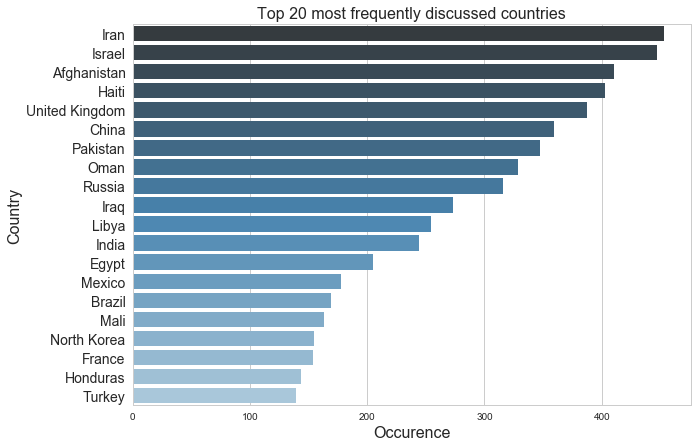

In [42]:
# plot the country occurence
sns.set(style="whitegrid", rc={'figure.figsize':(10, 7)})

occurences_plt = occurences_plt[1:21]
ax = sns.barplot(x = occurences_plt.values, y=occurences_plt.index, palette="Blues_d")
ax.set_title('Top 20 most frequently discussed countries', size=16)
ax.set_yticklabels(occurences_plt.index, size = 14)
ax.set_xlabel('Occurence', size = 16)
ax.set_ylabel('Country', size = 16);

In [43]:
id_occurence.to_csv('id_occurence.csv')